# Brainstorm

Link to Data Exploration Notebook: https://colab.research.google.com/drive/1HO6VlCgPWNTsW5BwathP13J_dxMiSSIQ?usp=sharing

## Exploration
1. Value counts by variable + plots

## Potential Target Variables
1. age: float
2. orientation: {0 = straight, 1 = gay/bisexual}
3. sex_cleaned: {0 = male, 1 = female}
4. body_type_cleaned: {average, fit, athletic, thin, curvy, a little extra, skinny, full figured}
5. diet_cleaned: {anything, vegetarian, other, vegan}
6. drugs_cleaned: {0 = no, 1 = yes}
7. education: {undergraduate, graduate, high school, other}
8. ethnicity: {white, asian, hispanic, black}
9. job_cleaned: {student, science, computer, artistic, sales, medicine, education, executive, banking, entertainment, law, hospitality, construction}
10. location_cleaned: {1 = from San Francisco, 0 = otherwise}
11. offspring_cleaned: {0 = no kids, 1 = has kids}
12. pets_cleaned: {0 = no pets, 1 = has pets}
13. religion_cleaned
14. sign_cleaned
15. sign_importance_cleaned: {0 = doesn't matter, 1 = fun to think about}
16. smokes_cleaned: {0 = no, 1 = yes}
17. multilingual: {0 = no, 1 = yes}
18. drinks_cleaned: {0 = no, 1 = yes}

## Feature Engineering
#### Text
1. tfidf vs. counts
2. Punctuation vs. remove punctuation
3. Stemming vs. no stemming
4. Unigram vs. bigram (vs. interpolation between the two)
5. Different dictionary sizes
6. Combining all essays vs. leaving them separate

## Models
1. Multi-class logistic
2. Neural Net

## Relevant Papers
1. https://www.researchgate.net/publication/282009623_OkCupid_Data_for_Introductory_Statistics_and_Data_Science_Courses


In [ ]:
# Sing's 

import csv
import string
import numpy as np
from sklearn import linear_model
from collections import defaultdict
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
nltk.download('stopwords')

In [ ]:
def read_data(path):
    with open(path) as csvfile:
        reader = csv.DictReader(csvfile)
        for d in reader:
            d["full_essay"] = " \n ".join([d[f'essay{i}'] for i in range(10)])
            yield d
            
data = list(read_data('okcupid_profiles.csv'))
train = data[:30000]
valid = data[30000:40000]
test = data[40000:]

In [ ]:
bigram_count = defaultdict(int)
unigram_count = defaultdict(int)

punct = string.punctuation
stemmer = PorterStemmer()
count = 0
for d in train:
    text = d["full_essay"]
    text = text.lower()
    text = [c for c in text if not (c in punct)]
    text = "".join(text)
    text = text.strip().split()
    text = [stemmer.stem(w) for w in text]
    
    for i in range(len(text) -1 ):
        bigram_count[(text[i], text[i+1])] += 1
    for i in range(len(text)):
        unigram_count[text[i]] += 1
        
    
    if count % 5000 ==0:
        print(count)
    count += 1
    
for sw in stopwords.words("english"):
    try:
        del unigram_count[sw]
    except KeyError:
        continue

    for a,b in list(bigram_count.keys()):
        if a == sw or b == sw:
            try:
                del bigram_count[(a,b)]
            except KeyError:
                pass
    
        
print("done")
print(len(bigram_count), len(unigram_count))

In [ ]:
idf = defaultdict(float)
total_doc = len(train)
for w,c in unigram_count.items():
    idf[w] = -np.log(c/total_doc)
for w,c in bigram_count.items():
    idf[w] = -np.log(c/total_doc)

In [ ]:
sorted_bigram_count = sorted(bigram_count.items(), key = lambda x:-x[1])
top_bigram = sorted_bigram_count[:1000]
top_bigram_words = [w for w,_ in top_bigram]

sorted_unigram_count = sorted(unigram_count.items(), key = lambda x:-x[1])
top_unigram = sorted_unigram_count[:1000]
top_unigram_words = [w for w,_ in top_unigram]


unigram_id = dict(zip(top_unigram_words, range(len(top_unigram_words))))
bigram_id = dict(zip(top_bigram_words, range(len(top_bigram_words))))

def feature(d): 
    text = d["full_essay"]
    text = text.lower()
    text = [c for c in text if not (c in punct)]
    text = "".join(text)
    text = text.strip().split()
    text = [stemmer.stem(w.strip()) for w in text]
        
    feat = [0]*( len(unigram_id)+len(bigram_id) )
    
    for w in text:
        if not w in unigram_id: continue
        feat[unigram_id[w]] += 1
    for i in range(len(text)-1):
        if not ((text[i], text[i+1]) in bigram_id): continue
        feat[len(unigram_id) + bigram_id[(text[i], text[i+1])]] += 1
        
    feat.append(1)
    return feat

body_class = [ ["athletic", "fit", "jacked"], ["average"], ["thin"], ["curvy", "a little extra", "full figured", "overweight"]]

def y_feature(d):
    feat = [0] * (len(body_class) + 1)
    for i, body_kind in enumerate(body_class):
        if d["body_type"] in body_kind:
            feat[i] = 1
            return feat
        
    feat[-1] = 1
    return feat

xtrain = [feature(d) for d in train]
ytrain = [y_feature(d) for d in train]

xvalid = [feature(d) for d in valid]
yvalid = [y_feature(d) for d in valid]

xtest = [feature(d) for d in test]
ytest = [y_feature(d) for d in test]

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(2001,)),
        layers.Dense(100, activation="relu"),
        layers.Dense(len(body_class) + 1, activation='softmax')
    ]
)

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=30,\
          callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)])



# Setup & Import Dataset

In [ ]:
import csv
import string
import numpy as np
import pandas as pd
from sklearn import linear_model
import xgboost
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import figure
import random
import seaborn as sns
# import shap
from collections import defaultdict
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Eiffel, Anshuman
path_to_data = '/content/drive/MyDrive/Colab Notebooks/okcupid_profiles.csv'

In [ ]:
# Read in data
#df = pd.read_csv(path_to_data)
df = pd.read_csv('/content/drive/MyDrive/profiles.csv')


# Randomize entries
df = df.reindex(np.random.permutation(df.index)).reset_index(drop=True)

## Data Cleaning

In [ ]:
df['height'] = df['height'].fillna(np.mean(df['height']))
df = df.fillna('NA')

In [ ]:
df['sex_cleaned'] = [1 if d == 'f' else 0 for d in df['sex']]

In [ ]:
df['orientation_cleaned'] = [0 if d == 'straight' else 1 for d in df['orientation']]

In [ ]:
df['body_type_cleaned'] = df['body_type'].map({
    'average':'average',
    'fit':'fit',
    'athletic':'athletic',
    'thin':'thin',
    'curvy':'curvy',
    'a little extra':'a little extra',
    'skinny':'skinny',
    'full figured':'full figured'
}).fillna('NA')

In [ ]:
df['diet_categories'] = [d.split()[1] if (len(d.split()) > 1) else d for d in df['diet']]

In [ ]:
df['diet_cleaned'] = df['diet_categories'].map({
    'anything':'anything',
    'vegetarian':'vegetarian',
    'vegan':'vegan',
    'NA':'NA'
}).fillna('other')

In [ ]:
df['drinks_cleaned'] = df['drinks'].map({
    'not at all': 0,
    'rarely': 0, 
    'NA': 'NA'
}).fillna(1)

In [ ]:
df['drugs_cleaned'] = df['drugs'].map({
    'never':0,
    'sometimes':1,
    'often':1
}).fillna('NA')

In [ ]:
df['education_cleaned'] = df['education'].map({
'graduated from college/university': 'undergraduate',
'graduated from masters program': 'graduate',        
'working on college/university': 'undergraduate',         
'working on masters program': 'graduate',            
'graduated from two-year college': 'undergraduate',       
'graduated from high school': 'high school',            
'graduated from ph.d program': 'graduate',           
'graduated from law school': 'graduate',             
'working on two-year college': 'undergraduate',           
'dropped out of college/university': 'high school',      
'working on ph.d program': 'graduate',                
'college/university': 'undergraduate',                     
'graduated from space camp': 'other',              
'dropped out of space camp': 'other',              
'graduated from med school': 'graduate',              
'working on space camp': 'other',                  
'working on law school': 'graduate',                  
'two-year college': 'undergraduate',                       
'working on med school': 'graduate',                  
'dropped out of two-year college': 'high school',        
'dropped out of masters program': 'undergraduate',         
'masters program': 'graduate',                        
'dropped out of ph.d program ': 'undergraduate',           
'dropped out of high school': 'other',             
'high school': 'high school',                             
'working on high school': 'high school',                  
'space camp': 'other',                              
'ph.d program ': 'graduate',                           
'law school': 'graduate',                              
'dropped out of law school': 'undergraduate',               
'dropped out of med school': 'undergraduate',               
'med school': 'graduate'}).fillna('NA')

In [ ]:
df['ethnicity_white'] = [1 if 'white' in d else 0 for d in df['ethnicity']]
df['ethnicity_asian'] = [1 if 'asian' in d else 0 for d in df['ethnicity']]
df['ethnicity_hispanic'] = [1 if 'hispanic' in d else 0 for d in df['ethnicity']]
df['ethnicity_black'] = [1 if 'black' in d else 0 for d in df['ethnicity']]

In [ ]:
eths = defaultdict(int)

for d in df['ethnicity']:
  for e in d.split(','):
    eths[e] += 1

In [ ]:
df['job_cleaned'] = df['job'].map({
    'NA':'NA',
    'student':'student',
    'science / tech / engineering':'science',
    'computer / hardware / software': 'computer',
    'artistic / musical / writer': 'artistic',
    'sales / marketing / biz dev': 'sales',
    'medicine / health': 'medicine',
    'education / academia': 'education',
    'executive / management': 'executive',
    'banking / financial / real estate': 'banking',
    'entertainment / media': 'entertainment',
    'law / legal services': 'law',
    'hospitality / travel': 'hospitality',
    'construction / craftsmanship': 'construction'
}).fillna('other')

In [ ]:
df['location_cleaned'] = [1 if d == 'san francisco, california' else 0 for d in df['location']]

In [ ]:
df['offspring_cleaned'] = df['offspring'].map({
    "doesn't have kids":0,
    "doesn't have kids, but might want them":0,
    "doesn't have kids, but wants them":0,
    "doesn't want kids":0,
    "doesn't have kids, and doesn't want any":0,
    "wants kids":0,
    "might want kids":0,
    "NA":"NA"
}).fillna(1)

In [ ]:
df['pets_cleaned'] = df['pets'].map({
    'has dogs': 1,
    'has dogs and likes cats': 1,
    'has dogs and has cats': 1,
    'has cats': 1,
    'has dogs and dislikes cats': 1,
    "NA":"NA"
}).fillna(0)

In [ ]:
df['religion_cleaned'] = [d.split()[0] if (len(d.split()) > 1) else d for d in df['religion']]

In [ ]:
df['sign_cleaned'] = [d.split()[0] if (len(d.split()) > 1) else d for d in df['sign']]

In [ ]:
df['sign_importance'] = [d.split()[len(d.split())-1] if (len(d.split()) > 1) else 'NA' for d in df['sign']]

In [ ]:
df['sign_importance_cleaned'] = df['sign_importance'].map({
    'NA':'NA',
    'about': 1, 
    'matter':0,
    'lot':1
})

In [ ]:
df['smokes_cleaned'] = df['smokes'].map({
    'no':0,
    'NA':'NA'
}).fillna(1)

In [ ]:
langs = defaultdict()

In [ ]:
df['num_languages'] = [len(d.split(',')) for d in df['speaks']]

In [ ]:
df['multilingual'] = [1 if d > 1 else 0 for d in df['num_languages']]

In [ ]:
langs = defaultdict(int)

for d in df['speaks']:
  for e in re.sub(r'\([^)]*\)', '', d).split(','):
    langs[e.strip()] += 1

In [ ]:
for i in range(10):
  title = 'essay' + str(i)
  newTitle = title + '_length'
  df[newTitle] = [len(d) for d in df[title]]

In [ ]:
for i in range(10):
  title = 'essay' + str(i)
  newTitle = title + '_length'
  # print(df[df[title] != 'NA'][newTitle].describe())

# Modeling

In [ ]:
def read_data(path):
    with open(path) as csvfile:
        reader = csv.DictReader(csvfile)
        for d in reader:
            d["full_essay"] = " \n ".join([d[f'essay{i}'] for i in range(10)])
            yield d
            
data = list(read_data(path_to_data))
train = data[:30000]
valid = data[30000:40000]
test = data[40000:]

In [ ]:
bigram_count = defaultdict(int)
unigram_count = defaultdict(int)

punct = string.punctuation
for d in train:
    text = d["full_essay"]
    text = text.lower()
    text = [c for c in text if not (c in punct)]
    text = ''.join(text)
    text = text.strip().split()
    
    for i in range(len(text) -1 ):
        bigram_count[(text[i], text[i+1])] += 1
    for i in range(len(text)):
        unigram_count[text[i]] += 1
        
print("done")

print(len(bigram_count), len(unigram_count))

done
2182309 170140


In [ ]:
idf = defaultdict(float)
total_doc = len(train)
for w,c in unigram_count.items():
    idf[w] = -np.log(c/total_doc)
for w,c in bigram_count.items():
    idf[w] = -np.log(c/total_doc)

In [ ]:
sorted_bigram_count = sorted(bigram_count.items(), key = lambda x:-x[1])
top_bigram = sorted_bigram_count[:1000]
top_bigram_words = [w for w,_ in top_bigram]

sorted_unigram_count = sorted(unigram_count.items(), key = lambda x:-x[1])
top_unigram = sorted_unigram_count[:1000]
top_unigram_words = [w for w,_ in top_unigram]


unigram_id = dict(zip(top_unigram_words, range(len(top_unigram_words))))
bigram_id = dict(zip(top_bigram_words, range(len(top_bigram_words))))

def feature(d):
    feat = [0]*len(unigram_id) 
    tf = defaultdict(int)
    
    for w in d["full_essay"]:
        tf[w] += 1
        
    for w in tf:
        if w not in unigram_id: continue
        feat[unigram_id[w]] = tf[w] * idf[w]
        
    # feat.append(1) # Don't need this, model adds by default
    return feat

xtrain = [feature(d) for d in train]
ytrain = ["c++" in d['speaks'] for d in train]

xvalid = [feature(d) for d in valid]
yvalid = ["c++" in d['speaks'] for d in valid]

xtest = [feature(d) for d in test]
ytest = ["c++" in d['speaks'] for d in test]

In [ ]:
clf = linear_model.LogisticRegression(C=1, solver='lbfgs', class_weight = 'balanced', max_iter=10000)
clf.fit(xtrain, ytrain)
predictions = clf.predict(xvalid)

In [ ]:
print("accuracy: ")
print(np.sum(np.logical_not( np.logical_xor( predictions, yvalid) ) )/ len(yvalid) )

accuracy: 
0.7119


In [ ]:
explainer = shap.Explainer(clf, np.array(xtrain))
shap_values = explainer(np.array(xtrain))

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


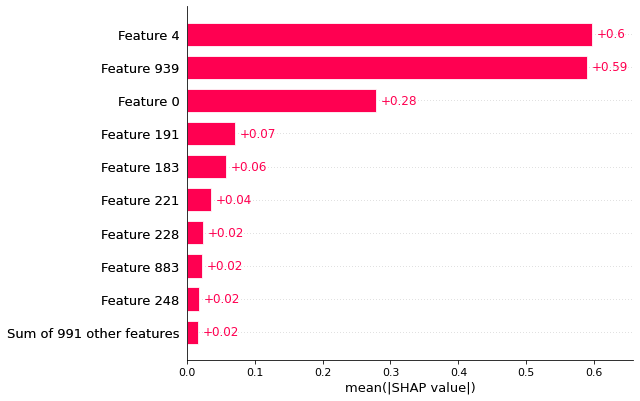

In [ ]:
shap.plots.bar(shap_values)

In [ ]:
unigram_id

{'i': 0,
 'and': 1,
 'the': 2,
 'to': 3,
 'a': 4,
 'of': 5,
 'my': 6,
 'in': 7,
 'im': 8,
 'you': 9,
 'with': 10,
 'for': 11,
 'that': 12,
 'is': 13,
 'have': 14,
 'it': 15,
 'like': 16,
 'on': 17,
 'or': 18,
 'me': 19,
 'but': 20,
 'am': 21,
 'love': 22,
 'at': 23,
 'be': 24,
 'not': 25,
 'are': 26,
 'out': 27,
 'good': 28,
 'as': 29,
 'if': 30,
 'music': 31,
 'friends': 32,
 'people': 33,
 'about': 34,
 'life': 35,
 'time': 36,
 'all': 37,
 'can': 38,
 'so': 39,
 'just': 40,
 'things': 41,
 'do': 42,
 'food': 43,
 'what': 44,
 'an': 45,
 'this': 46,
 'dont': 47,
 'new': 48,
 'up': 49,
 'really': 50,
 'also': 51,
 'from': 52,
 'more': 53,
 'some': 54,
 'who': 55,
 'its': 56,
 'get': 57,
 'how': 58,
 'movies': 59,
 'when': 60,
 'know': 61,
 'want': 62,
 'work': 63,
 'by': 64,
 'one': 65,
 'being': 66,
 'ive': 67,
 'think': 68,
 'books': 69,
 'anything': 70,
 'enjoy': 71,
 'much': 72,
 'going': 73,
 'family': 74,
 'go': 75,
 'was': 76,
 'will': 77,
 'make': 78,
 'been': 79,
 'would': 80

In [ ]:
# Sachin, predicting age with regressions

In [ ]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [ ]:
# baseline
ages = df['age']
labels = list(ages)

mean_age = sum(ages) / len(ages)
median_age = sorted(ages)[len(ages)//2]

mean_baseline = [mean_age] * len(ages)
median_baseline = [median_age] * len(ages)

print('The mean age is:', mean_age)
print('The median age is:', median_age)

print('Mean baseline:', MSE(mean_baseline, labels))
print('Median baseline:', MSE(median_baseline, labels))

The mean age is: 32.3402895939679
The median age is: 30
Mean baseline: 89.35354206405898
Median baseline: 94.83049744770294


In [ ]:
# remove outliers from the dataset
dataset = []
for ind in df.index: 
    if 18 <= df['age'][ind] and df['age'][ind] <= 80:
        dataset.append(df.loc[ind])

In [ ]:
# stuff for feature generation

# diet 1-hot vector
df['diet_categories'] = [d.split()[1] if (len(d.split()) > 1) else d for d in df['diet']]
df['diet_cleaned'] = df['diet_categories'].map({
    'anything':'anything',
    'vegetarian':'vegetarian',
    'vegan':'vegan',
    'NA':'NA'
}).fillna('other')
diet_to_idx = {
    'anything':0,
    'vegetarian':1,
    'vegan':2,
    'NA':3,
    'other':4
}

# drugs 1-hot vector
df['drugs_cleaned'] = df['drugs'].map({
    'never':0,
    'sometimes':1,
    'often':1
}).fillna('NA')
drugs_to_idx = {
    'never':0,
    'sometimes':1,
    'often':2,
    'NA':3
}

# smoke 1-hot vector
df['smokes_cleaned'] = df['smokes'].map({
    'no':0,
    'NA':'NA'
}).fillna(1)
smokes_to_idx = {
    '0':0,
    '1':1,
    'NA':2
}

# drinks 1-hot vector
df['drinks_cleaned'] = df['drinks'].map({
    'not at all': 0,
    'rarely': 0, 
    'NA': 'NA'
}).fillna(1)
drinks_to_idx = {
    '0':0,
    '1':1,
    'NA':2
}

# education 1-hot vector
df['education_cleaned'] = df['education'].map({
'graduated from college/university': 'undergraduate',
'graduated from masters program': 'graduate',        
'working on college/university': 'undergraduate',         
'working on masters program': 'graduate',            
'graduated from two-year college': 'undergraduate',       
'graduated from high school': 'high school',            
'graduated from ph.d program': 'graduate',           
'graduated from law school': 'graduate',             
'working on two-year college': 'undergraduate',           
'dropped out of college/university': 'high school',      
'working on ph.d program': 'graduate',                
'college/university': 'undergraduate',                     
'graduated from space camp': 'other',              
'dropped out of space camp': 'other',              
'graduated from med school': 'graduate',              
'working on space camp': 'other',                  
'working on law school': 'graduate',                  
'two-year college': 'undergraduate',                       
'working on med school': 'graduate',                  
'dropped out of two-year college': 'high school',        
'dropped out of masters program': 'undergraduate',         
'masters program': 'graduate',                        
'dropped out of ph.d program ': 'undergraduate',           
'dropped out of high school': 'other',             
'high school': 'high school',                             
'working on high school': 'high school',                  
'space camp': 'other',                              
'ph.d program ': 'graduate',                           
'law school': 'graduate',                              
'dropped out of law school': 'undergraduate',               
'dropped out of med school': 'undergraduate',               
'med school': 'graduate'}).fillna('NA')
education_to_idx = {
    'undergraduate':0,
    'graduate':1,
    'NA':2,
    'high school':3,
    'other':4
}

# pet 1-hot vector
df['pets_cleaned'] = df['pets'].map({
    'has dogs': 1,
    'has dogs and likes cats': 1,
    'has dogs and has cats': 1,
    'has cats': 1,
    'has dogs and dislikes cats': 1,
    "NA":"NA"
}).fillna(0)
pets_to_idx = {
    '0':0,
    'NA':1,
    '1':2
}

# body type 1-hot vector
df['body_type_cleaned'] = df['body_type'].map({
    'average':'average',
    'fit':'fit',
    'athletic':'athletic',
    'thin':'thin',
    'curvy':'curvy',
    'a little extra':'a little extra',
    'skinny':'skinny',
    'full figured':'full figured'
}).fillna('NA')
body_type_to_idx = {
    'average':0,
    'fit':1,
    'athletic':2,
    'NA':3,
    'thin':4,
    'curvy':5,
    'a little extra':6,
    'skinny':7,
    'full figured':8
}

In [ ]:
# feature generation
def feature(X):
    features = []

    diet = [0] * len(diet_to_idx)
    if X['diet'] in diet_to_idx:
        diet[diet_to_idx[X['diet']]] = 1
    features.extend(diet)

    drugs = [0] * len(drugs_to_idx)
    if X['drugs'] in drugs_to_idx:
        drugs[drugs_to_idx[X['drugs']]] = 1
    features.extend(drugs)

    smokes = [0] * len(smokes_to_idx)
    if X['smokes'] in smokes_to_idx:
        smokes[smokes_to_idx[X['smokes']]] = 1
    features.extend(smokes)

    drinks = [0] * len(drinks_to_idx)
    if X['drinks'] in drinks_to_idx:
        drinks[drinks_to_idx[X['drinks']]] = 1
    features.extend(drinks)

    education = [0] * len(education_to_idx)
    if X['education'] in education_to_idx:
        education[education_to_idx[X['education']]] = 1
    features.extend(education)

    pets = [0] * len(pets_to_idx)
    if X['pets'] in pets_to_idx:
        pets[pets_to_idx[X['pets']]] = 1
    features.extend(pets)

    body_type = [0] * len(body_type_to_idx)
    if X['body_type'] in body_type_to_idx:
        body_type[body_type_to_idx[X['body_type']]] = 1
    features.extend(body_type)

    features.extend([X['income']])

    features.extend([X['height']])

    essays = ['essay0', 'essay1', 'essay2', 'essay3', 'essay4', 'essay5', \
              'essay6', 'essay7', 'essay8', 'essay9']
    avg_essay_length = sum([len(X[essay]) for essay in essays]) / len(essays)
    features.extend([avg_essay_length])

    features.append(1)
    
    return features

In [ ]:
# make train and validation sets
random.shuffle(dataset)
train_data = dataset[:(len(dataset) // 2)]
valid_data = dataset[(len(dataset) // 2):]
X = []
y = []
for x in train_data:
    X.append(feature(x))
    y.append(x['age'])

In [ ]:
# find MSE of this on regular linear regression
train_feats = [feature(x) for x in train_data]
valid_feats = [feature(x) for x in valid_data]
print('MSE with normal linear regression')

theta,residuals,rank,s = np.linalg.lstsq(X, y)

# training error
MSE_error =  0
for idx in range(0, len(train_feats)):
    train_vector = train_feats[idx]
    label = y[idx]
    residual = 0

    for idx in range(0, len(theta)):
        residual += (theta[idx] * float(train_vector[idx]))
    
    MSE_error += (label - residual) ** 2

MSE_error /= len(train_feats)
print('MSE Error on train data:', MSE_error)

# validation error
MSE_error =  0
for idx in range(0, len(valid_feats)):
    valid_vector = valid_feats[idx]
    label = y[idx]
    residual = 0

    for idx in range(0, len(theta)):
        residual += (theta[idx] * float(valid_vector[idx]))
    
    MSE_error += (label - residual) ** 2

MSE_error /= len(valid_feats)
print('MSE Error on validation data:', MSE_error)

MSE with normal linear regression


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


MSE Error on train data: 85.23542098317374
MSE Error on validation data: 94.37142064698855


In [ ]:
print('This beats the median baseline, but doesn\'t generalize well enough to beat the mean baseline.')

This beats the median baseline, but doesn't generalize well enough to beat the mean baseline.


In [ ]:
print('MSE with Lasso, favors feature vectors with more 0 values, better since using a lot of 1-hot vectors')
alpha_vals = [10 ** (n - 5) for n in range(0, 20)]
print(alpha_vals)
for a in alpha_vals:
    reg = linear_model.Lasso(alpha=a)
    reg.fit(X, y)
    pred = reg.predict(valid_feats)
    print('MSE on Lasso with alpha =', a, end=' : ')
    print(MSE(labels, pred))
  # so, the best alpha value is ~1000, with a MSE of 88.88120022056228, that beats the mean baseline 

MSE with Lasso, favors feature vectors with more 0 values, better since using a lot of 1-hot vectors
[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000, 100000000000, 1000000000000, 10000000000000, 100000000000000]
MSE on Lasso with alpha = 1e-05 : 94.18899793386531
MSE on Lasso with alpha = 0.0001 : 94.18331455555854
MSE on Lasso with alpha = 0.001 : 94.12836237474342
MSE on Lasso with alpha = 0.01 : 93.64486955165327
MSE on Lasso with alpha = 0.1 : 91.43105800683557
MSE on Lasso with alpha = 1 : 90.1720704840132
MSE on Lasso with alpha = 10 : 90.11115969556725
MSE on Lasso with alpha = 100 : 89.72710383582447
MSE on Lasso with alpha = 1000 : 89.68922562075335
MSE on Lasso with alpha = 10000 : 89.68922562075335
MSE on Lasso with alpha = 100000 : 89.68922562075335
MSE on Lasso with alpha = 1000000 : 89.68922562075335
MSE on Lasso with alpha = 10000000 : 89.68922562075335
MSE on Lasso with alpha = 100000000 : 89.68922

In [ ]:
print('This beats both the mean and median baselines! Hard to go further than this since a lot of features don\'t separate age')

This beats both the mean and median baselines! Hard to go further than this since a lot of features don't separate age
